#Обучение моделей и подбор гиперпараметров
В этом блокноте проводится обучение нескольких моделей машинного обучения на наборе данных `df_significant` с оптимизацией  гиперпараметров. Использованные модели: логистическая регрессия, случайный лес, XGBoost, SVM, Gradient Boosting и LightGBM.


##Установка и импорт необходимых библиотек

In [1]:
!pip install lightgbm

In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 12.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from google.colab import files




## Загрузка данных и предобработка
Загружаем набора данных `df_significant.csv`, кодируем целевую перменную. Разделяем данные на обучающую и тестовую выборки


In [4]:
df_significant = pd.read_csv("df_significant.csv")

In [5]:
df_significant.head(5)

,work_interfere_No data,work_interfere_Sometimes,work_interfere_Never,family_history_Yes,family_history_No,work_interfere_Often,care_options_Yes,benefits_Yes,Standardized_gender_female,benefits_Don't know,...,mental_health_consequence_Yes,seek_help_Yes,mental_vs_physical_Don't know,wellness_program_Yes,leave_Don't know,Standardized_gender_other,no_employees_6-25,coworkers_Yes,obs_consequence_No,treatment
0,False,True,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,True,False,0
1,True,False,False,True,False,False,False,False,False,False,...,False,False,True,True,False,False,True,False,True,0
2,False,True,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,True,1
3,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0
4,False,False,False,False,True,True,True,True,False,False,...,False,False,False,False,True,False,False,False,True,1


In [6]:
X = df_significant.drop('treatment', axis=1)
y= df_significant['treatment']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [7]:
df_significant['treatment'] = df_significant['treatment'].map({'Yes': 1, 'No': 0})


In [8]:
# Приведение названий признаков в обучающем и тестовом наборах к одинаковому формату
X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)


## Функции для обучения, оценки и подбора гиперпараметров



Функция для обучения каждой модели, предсказания и оценки её точности. Также для вывода отчёта с метриками классификации.

In [9]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.time()

    # Обучаем модель
    model.fit(X_train, y_train)

    # Предсказываем на тестовых данных
    y_pred = model.predict(X_test)

    # Оценка модели
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"{model_name}:")
    print(f"Точность: {accuracy}")
    print(f"Отчет классификации:\n{report}")
    print(f"Время выполнения: {time.time() - start_time:.2f} секунд\n")

    return accuracy

Функция для подбора гиперпараметров: для каждой модели будет проведен поиск оптимальных гиперпараметров

In [10]:
# Функция для гиперпараметрической оптимизации
def hyperparameter_optimization(model, param_grid, X_train, y_train, model_name, search_type="grid"):
    start_time = time.time()

    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    else:
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

    search.fit(X_train, y_train)

    print(f"Лучшие параметры для {model_name}: {search.best_params_}")
    print(f"Лучшая точность: {search.best_score_}")
    print(f"Время поиска: {time.time() - start_time:.2f} секунд\n")

    return search.best_params_, search.best_score_

##Создание, обучение моделей и подбор гиперпарамтеров

In [11]:
# Создание моделей
log_reg = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(random_state=99)
xgb_model = xgb.XGBClassifier(random_state=99)
svm_model = SVC(random_state=99)
gb_model = GradientBoostingClassifier()
lgb_model = LGBMClassifier()

In [12]:
# Обучение моделей
log_reg_accuracy = train_and_evaluate(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")
rf_accuracy = train_and_evaluate(rf_model, X_train, X_test, y_train, y_test, "Random Forest")
xgb_accuracy = train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
svm_accuracy = train_and_evaluate(svm_model, X_train, X_test, y_train, y_test, "SVM")
gb_accuracy = train_and_evaluate(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")
lgb_accuracy = train_and_evaluate(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")


Logistic Regression:
Точность: 0.8396739130434783
Отчет классификации:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       190
           1       0.78      0.94      0.85       178

    accuracy                           0.84       368
   macro avg       0.85      0.84      0.84       368
weighted avg       0.85      0.84      0.84       368

Время выполнения: 0.08 секунд

Random Forest:
Точность: 0.8125
Отчет классификации:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       190
           1       0.77      0.88      0.82       178

    accuracy                           0.81       368
   macro avg       0.82      0.81      0.81       368
weighted avg       0.82      0.81      0.81       368

Время выполнения: 0.61 секунд

XGBoost:
Точность: 0.7853260869565217
Отчет классификации:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78   

In [13]:
# Гиперпараметрическая оптимизация
# Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
}
best_rf_params, best_rf_score = hyperparameter_optimization(rf_model, rf_param_grid, X_train, y_train, "Random Forest", search_type="grid")

# XGBoost с RandomizedSearchCV
xgb_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}
best_xgb_params, best_xgb_score = hyperparameter_optimization(xgb_model, xgb_param_dist, X_train, y_train, "XGBoost", search_type="random")

# SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # разные ядра
    'gamma': ['scale', 'auto']
}
best_svm_params, best_svm_score = hyperparameter_optimization(svm_model, svm_param_grid, X_train, y_train, "SVM", search_type="grid")

# Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
best_gb_params, best_gb_score = hyperparameter_optimization(gb_model, gb_param_grid, X_train, y_train, "Gradient Boosting", search_type="grid")

# LightGBM
lgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 5, 10],
    'num_leaves': [31, 63]
}
best_lgb_params, best_lgb_score = hyperparameter_optimization(lgb_model, lgb_param_grid, X_train, y_train, "LightGBM", search_type="grid")




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры для Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучшая точность: 0.8274037807697538
Время поиска: 24.19 секунд

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры для XGBoost: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Лучшая точность: 0.8286413708690331
Время поиска: 24.95 секунд

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры для SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Лучшая точность: 0.8286141710866313
Время поиска: 1.48 секунд

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры для Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Лучшая точность: 0.8286141710866313
Время поиска: 30.27 секунд

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 442, number o

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


##Сравнение результатов моделей

Создание таблицы с результатми для дальнешей визуализации

In [14]:
# Сравнение результатов всех моделей
model_results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM", "Gradient Boosting", "LightGBM"],
    "Accuracy": [log_reg_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy, gb_accuracy, lgb_accuracy]
}

df_results = pd.DataFrame(model_results)

In [15]:
styled_results = df_results.style.format({"Accuracy": "{:.4f}"})

print("Результаты всех моделей:")
display(styled_results)



Результаты всех моделей:


,Model,Accuracy
0,Logistic Regression,0.8397
1,Random Forest,0.8125
2,XGBoost,0.7853
3,SVM,0.8342
4,Gradient Boosting,0.8234
5,LightGBM,0.8043


Визуализация результатов

<ipython-input-16-1a593cc93af0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_results, palette='pastel')


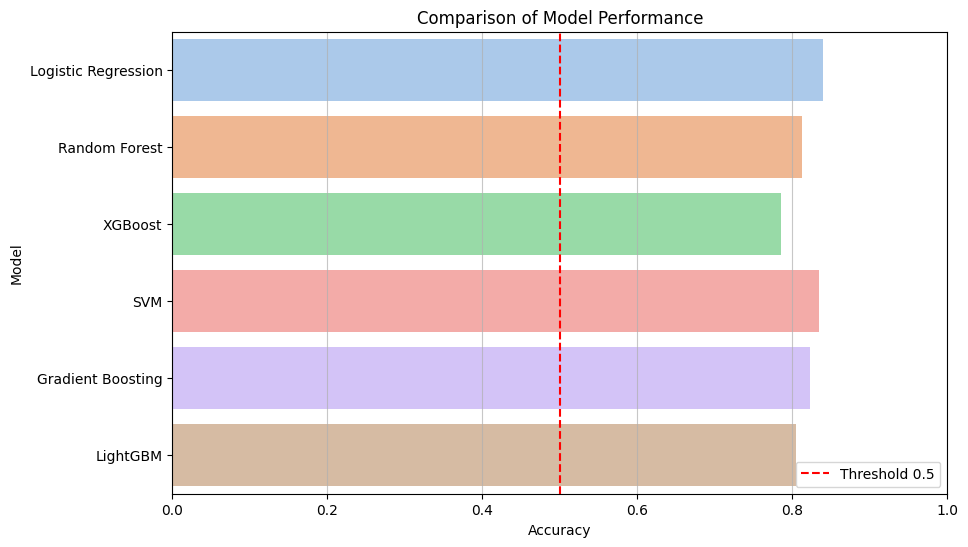

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df_results, palette='pastel')
plt.title('Comparison of Model Performance')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.grid(axis='x', alpha=0.7)
plt.legend()
plt.show()

Наилучший результат показали **логистическая регрессия** и **SVM**. Остальные модели также были довольно эффективны, однако наихудший показатель точности был у XGBoost. Эти результаты свидетельствуют о высоком качестве данных и о наличии ясных паттернов в них.